
Digite o caminho completo do arquivo .tsp (ex.: /home/user/att48.tsp):


Caminho:  C:\Users\Thiago\Documents\Algoritmos Evolucionários - Python\data\ATT\att48.tsp



Executando experimento para taxa_crossover = 0

Executando experimento para taxa_crossover = 0.1

Executando experimento para taxa_crossover = 0.2

Executando experimento para taxa_crossover = 0.3

Executando experimento para taxa_crossover = 0.4

Executando experimento para taxa_crossover = 0.5

Executando experimento para taxa_crossover = 0.6

Executando experimento para taxa_crossover = 0.7

Executando experimento para taxa_crossover = 0.8

Executando experimento para taxa_crossover = 0.9

Executando experimento para taxa_crossover = 1

Resumo:
           parametro  valor  execucao   melhor_custo  \
0    taxa_crossover    0.0         0  129079.964426   
1    taxa_crossover    0.0         1  135744.083847   
2    taxa_crossover    0.0         2  131556.908956   
3    taxa_crossover    0.0         3  136505.229184   
4    taxa_crossover    0.0         4  130143.745100   
..              ...    ...       ...            ...   
105  taxa_crossover    1.0         5  127272.429224   
106 

C:\Users\Thiago\AppData\Local\Temp\ipykernel_16380\65342296.py:267: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(dados_por_valor, labels=[str(v) for v in valores])


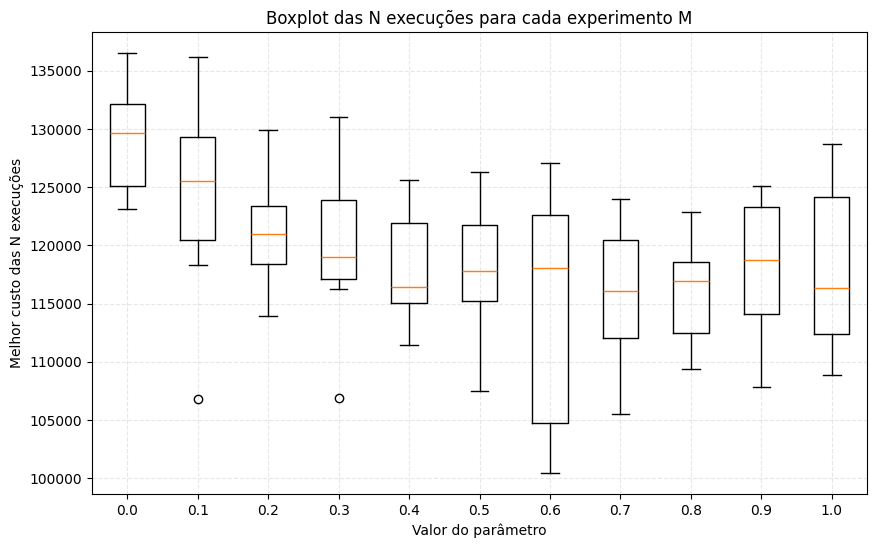

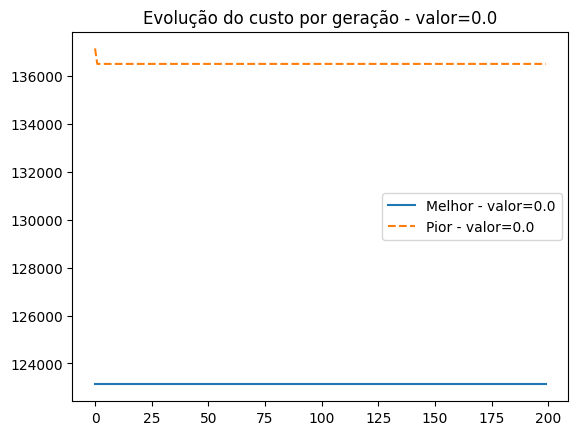

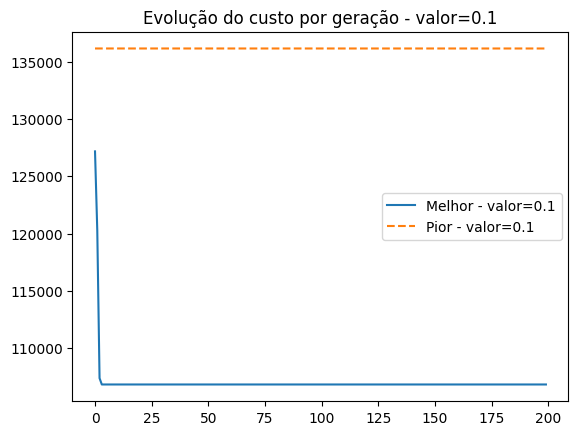

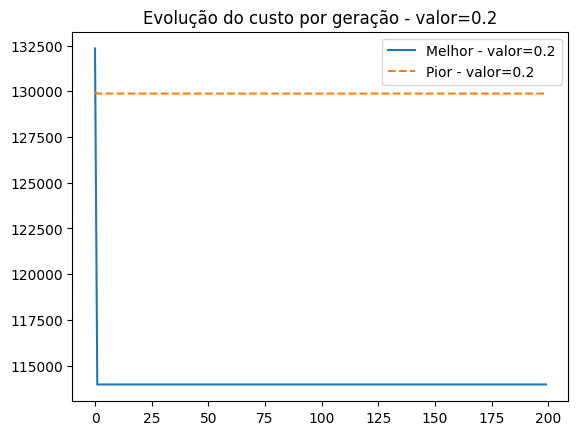

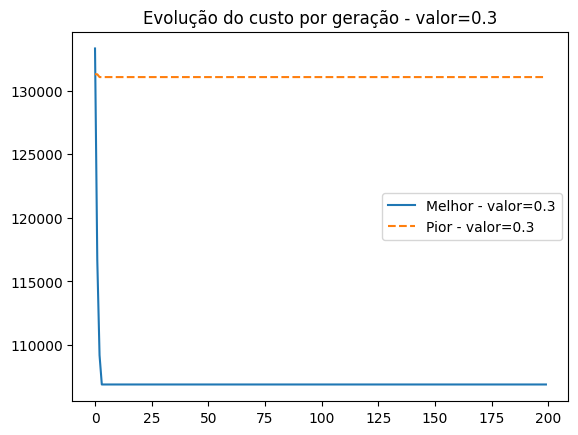

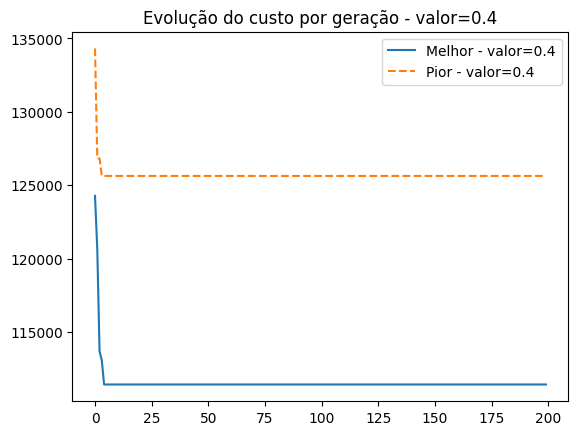

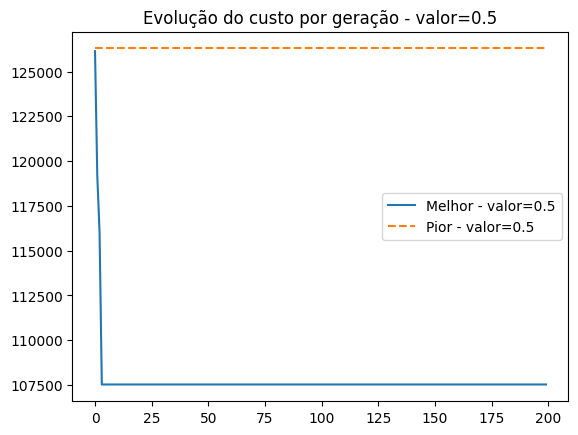

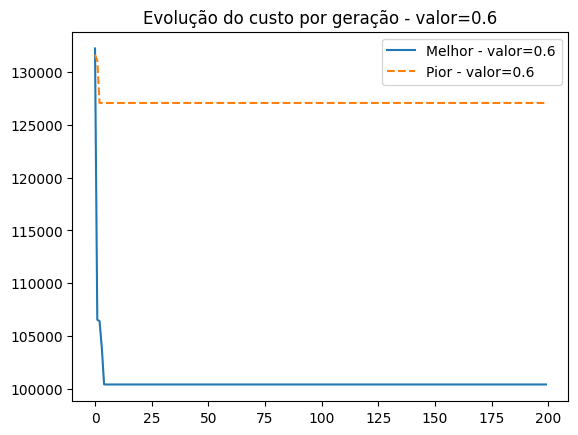

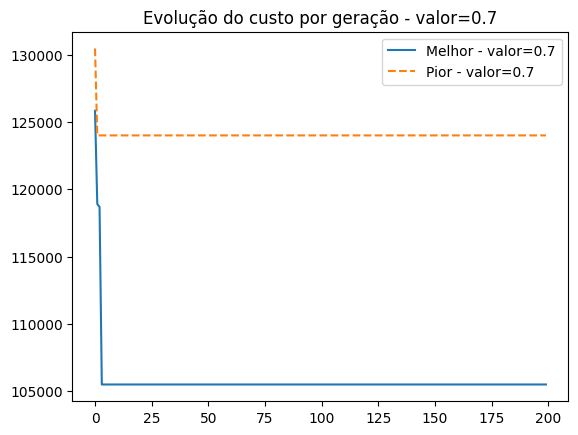

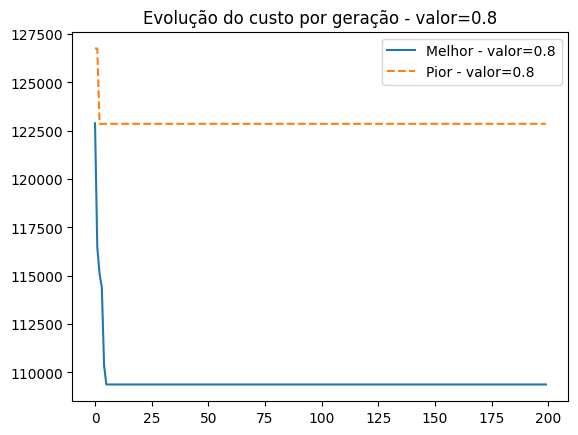

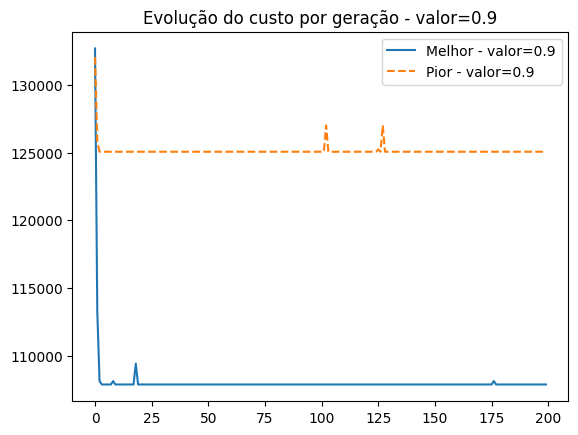

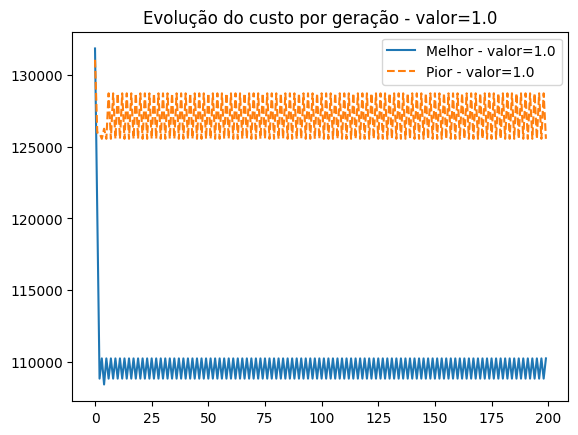

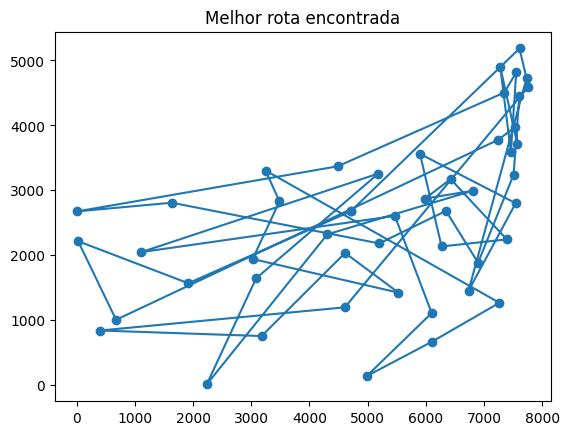

In [2]:
import random
import math
import pandas as pd
import matplotlib.pyplot as plt


# ============================================================
# 1. Leitura do arquivo .tsp
# ============================================================

def selecionar_arquivo_tsp():
    print("\nDigite o caminho completo do arquivo .tsp (ex.: /home/user/att48.tsp):")
    caminho = input("Caminho: ").strip()
    return caminho


def ler_tsp(path):
    coords = []
    with open(path, "r") as f:
        for linha in f:
            partes = linha.strip().split()
            if len(partes) == 3 and partes[0].isdigit():
                x = float(partes[1])
                y = float(partes[2])
                coords.append((x, y))
    return coords


def calcular_matriz_distancias(coords):
    n = len(coords)
    dist = [[0]*n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            xi, yi = coords[i]
            xj, yj = coords[j]
            dist[i][j] = math.sqrt((xi - xj)**2 + (yi - yj)**2)
    return dist


# ============================================================
# 2. Estruturas do Algoritmo Genético
# ============================================================

def custo_rota(rota, dist):
    total = 0
    for i in range(len(rota)):
        a = rota[i]
        b = rota[(i+1) % len(rota)]
        total += dist[a][b]
    return total


def criar_individuo(n):
    rota = list(range(n))
    random.shuffle(rota)
    return rota


# ----------------------
# Seleção
# ----------------------

def selecao_torneio(populacao, fitness, k):
    selecionados = random.sample(range(len(populacao)), k)
    melhor = min(selecionados, key=lambda i: fitness[i])
    return populacao[melhor][:]


def selecao_roleta(populacao, fitness):
    inv_fit = [1/f for f in fitness]
    total = sum(inv_fit)
    probs = [x/total for x in inv_fit]
    r = random.random()
    acumulado = 0
    for i, p in enumerate(probs):
        acumulado += p
        if acumulado >= r:
            return populacao[i][:]


def selecao_elitismo(populacao, fitness, taxa=0.1):
    n = len(populacao)
    qtd_elite = max(1, int(n * taxa))
    elite_idx = sorted(range(n), key=lambda i: fitness[i])[:qtd_elite]
    escolhido = random.choice(elite_idx)
    return populacao[escolhido][:]


# ----------------------
# Crossover OX
# ----------------------

def crossover_ox(pai1, pai2, corte_fixo=True):
    n = len(pai1)

    if corte_fixo:
        a, b = n//3, 2*n//3
    else:
        a, b = sorted([random.randint(0, n-1), random.randint(0, n-1)])

    filho = [None]*n
    filho[a:b] = pai1[a:b]

    pos = b
    for x in pai2:
        if x not in filho:
            if pos >= n:
                pos = 0
            filho[pos] = x
            pos += 1

    return filho


# ----------------------
# Mutação
# ----------------------

def mutacao_swap(ind, taxa_mutacao, posicao_fixa=True):
    if random.random() < taxa_mutacao:
        n = len(ind)
        if posicao_fixa:
            i, j = 0, n-1
        else:
            i, j = random.sample(range(n), 2)
        ind[i], ind[j] = ind[j], ind[i]
    return ind


# ============================================================
# 3. Algoritmo Genético
# ============================================================

def algoritmo_genetico(dist, geracoes=200, tamanho_pop=100,
                       metodo_selecao="", k_torneio=3,
                       taxa_crossover=0.9, corte_fixo=True,
                       taxa_mutacao=0.3, mutacao_fixa=True,
                       elitismo=False, taxa_elite=0.1):

    n = len(dist)
    populacao = [criar_individuo(n) for _ in range(tamanho_pop)]
    melhor_historico = []

    for gen in range(geracoes):

        fitness = [custo_rota(ind, dist) for ind in populacao]
        melhor_historico.append(min(fitness))

        nova_pop = []

        if elitismo:
            qtd = max(1, int(tamanho_pop * taxa_elite))
            elite_idx = sorted(range(tamanho_pop), key=lambda i: fitness[i])[:qtd]
            for i in elite_idx:
                nova_pop.append(populacao[i][:])

        while len(nova_pop) < tamanho_pop:
            # seleção
            if metodo_selecao == "torneio":
                p1 = selecao_torneio(populacao, fitness, k_torneio)
                p2 = selecao_torneio(populacao, fitness, k_torneio)
            elif metodo_selecao == "roleta":
                p1 = selecao_roleta(populacao, fitness)
                p2 = selecao_roleta(populacao, fitness)
            else:
                p1 = selecao_elitismo(populacao, fitness, taxa_elite)
                p2 = selecao_elitismo(populacao, fitness, taxa_elite)

            # crossover
            if random.random() < taxa_crossover:
                f1 = crossover_ox(p1, p2, corte_fixo)
                f2 = crossover_ox(p2, p1, corte_fixo)
            else:
                f1, f2 = p1[:], p2[:]

            # mutação
            f1 = mutacao_swap(f1, taxa_mutacao, mutacao_fixa)
            f2 = mutacao_swap(f2, taxa_mutacao, mutacao_fixa)

            nova_pop.append(f1)
            if len(nova_pop) < tamanho_pop:
                nova_pop.append(f2)

        populacao = nova_pop

    # retorno
    fitness_final = [custo_rota(ind, dist) for ind in populacao]
    melhor = min(range(tamanho_pop), key=lambda i: fitness_final[i])

    return populacao[melhor], min(fitness_final), melhor_historico


# ============================================================
# 4. Experimentos M × N
# ============================================================

def executar_experimentos(dist,
                          parametro="taxa_mutacao",
                          valores=[0.0,0.1,0.2,0.3],
                          N=5,
                          geracoes=200):

    registros = []

    for val in valores:
        print(f"\nExecutando experimento para {parametro} = {val}")

        for execucao in range(N):

            if parametro == "taxa_mutacao":
                melhor_rota, melhor_custo, hist = algoritmo_genetico(
                    dist,
                    taxa_mutacao=val,
                    geracoes=geracoes
                )

            elif parametro == "taxa_crossover":
                melhor_rota, melhor_custo, hist = algoritmo_genetico(
                    dist,
                    taxa_crossover=val,
                    geracoes=geracoes
                )

            elif parametro == "k_torneio":
                melhor_rota, melhor_custo, hist = algoritmo_genetico(
                    dist,
                    k_torneio=int(val),
                    geracoes=geracoes
                )

            elif parametro == "populacao":
                melhor_rota, melhor_custo, hist = algoritmo_genetico(
                    dist,
                    tamanho_pop=int(val),
                    geracoes=geracoes
                )

            registros.append({
                "parametro": parametro,
                "valor": val,
                "execucao": execucao,
                "melhor_custo": melhor_custo,
                "hist": hist,
                "rota": melhor_rota
            })

    df = pd.DataFrame(registros)
    return df


# ============================================================
# 5. Gráficos auxiliares
# ============================================================
def plot_boxplot(df):
    """
    Produz M boxplots lado a lado.
    Cada boxplot contém as N execuções para um valor do parâmetro.
    """
    valores = sorted(df["valor"].unique())

    dados_por_valor = []
    for v in valores:
        custos = df[df["valor"] == v]["melhor_custo"].tolist()
        dados_por_valor.append(custos)

    plt.figure(figsize=(10, 6))
    plt.boxplot(dados_por_valor, labels=[str(v) for v in valores])
    plt.xlabel("Valor do parâmetro")
    plt.ylabel("Melhor custo das N execuções")
    plt.title("Boxplot das N execuções para cada experimento M")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.show()



def plot_evolucoes(df):
    valores = df["valor"].unique()
    for val in valores:
        subset = df[df["valor"] == val]

        melhor = subset.sort_values("melhor_custo").iloc[0]
        pior = subset.sort_values("melhor_custo").iloc[-1]

        plt.plot(melhor["hist"], label=f"Melhor - valor={val}")
        plt.plot(pior["hist"], label=f"Pior - valor={val}", linestyle='--')
        plt.title(f"Evolução do custo por geração - valor={val}")
        plt.legend()
        plt.show()


def plot_melhor_rota(coords, rota):
    xs = [coords[i][0] for i in rota] + [coords[rota[0]][0]]
    ys = [coords[i][1] for i in rota] + [coords[rota[0]][1]]

    plt.plot(xs, ys, marker="o")
    plt.title("Melhor rota encontrada")
    plt.show()


# ============================================================
# 6. Execução principal
# ============================================================

if __name__ == "__main__":
    arq = selecionar_arquivo_tsp()
    coords = ler_tsp(arq)
    dist = calcular_matriz_distancias(coords)

    df = executar_experimentos(
        dist,
        parametro="taxa_crossover",
        valores=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
        N=10,
        geracoes=200
    )

    print("\nResumo:\n", df)

    plot_boxplot(df)
    plot_evolucoes(df)

    melhor_global = df.sort_values("melhor_custo").iloc[0]
    plot_melhor_rota(coords, melhor_global["rota"])
